# Assignment 4


Comments:

- Make sure that everything is compiled before saving it.
- Obviously feel free to add as many cells as needed in each section.
- Cells should not be too large. Keep code organized and clean.

## Write your names and simon emails

Please write names below:

* [Name,email]:
* [Name,email]:





# Exercises




**Exercise 1**

In order to proceed you need the file `url="https://github.com/amoreira2/Fin418/blob/main/assets/data/crspm2005_2020.pkl?raw=true"`. 


Start by importing the data, parsing the date appropriately.


Using the momentum code we developed in chapter 13.2 as a starting point, I would like you to make it a general function that takes the following parameters as inputs:

   - lookback period. 
   - how many months to skip between signal and portfolio formation.
   - number of groups, i.e., the number of portfolios.
   - weighting scheme: equal-weighted, market-cap-weighted, volume-weighted.
 
The signal is the cumulative returns in the lookback window.
   

   
The code should output **a time-series of returns** of the portfolio that goes long the top group (the one in the top of the signal distribution) and shorts the bottom group (the one with stocks from the bottom of the signal distribution).


Name this function `strategy`.

TIP:

This is the same data set that we used in Chapter 13.1 to build market cap weights. So you should look there how things were setup and of course, the same data set we used in chapter 13.2.

It is your reponsibility to import this properly and adjust to any aspects of the dataset. For example, make sure you take absolute values of price to ensure that market cap is positive.


In [1]:
# your code below
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

url= "https://github.com/amoreira2/Fin418/blob/main/assets/data/crspm2005_2020.pkl?raw=true"
df = pd.read_pickle(url)
df[['permno']]=df[['permno']].astype(int)
df.head()


,permno,date,shrcd,exchcd,ret,shrout,prc,retx,vol
0,11671,2005-01-31,11.0,3.0,0.016491,3692.0,2.219000,0.016491,722.0
1,10001,2005-01-31,11.0,3.0,-0.040580,2595.0,6.620000,-0.040580,515.0
2,10002,2005-01-31,11.0,3.0,-0.132466,11021.0,21.350000,-0.132466,3872.0
3,11674,2005-01-31,11.0,1.0,0.015766,173958.0,43.810001,0.015766,116791.0
4,11681,2005-01-31,11.0,2.0,0.337143,18388.0,2.340000,0.337143,6260.0


In [2]:
def strategy(df,ngroups=10,lookback=11,skip=2,weight="ew"):


    # This function takes a data frame with columns 'permno' = stock identifier, 'ret' = returns, 'date' = date,
    # 'shrout' = shares outstanding, 'prc' = price, 'vol' = volume traded;
    # It creates a momentum strategy with arguments lookback, for the lookback period, skip, for skipping a number of months
    # between the estimation and the portfolio formation period, and weight = {"ew", "mw", "vw"} which denotes
    # equal weighted, market weighted and volume weighted. The output is the return of a portfolio that goes 
    # long the group of assets with the highest momentum and shorts the group of assets with the lowest. 
    # ngroups is the number of groups we choose to partition the assets.
    
    df['mcap'] = df['prc'].abs()*df['shrout'] # creating the market cap column
    df['gross'] = 1+df['ret']
    df=df.set_index(['date'])
    temp=(df.groupby('permno')[['gross']]).rolling(window=lookback,min_periods=int(np.ceil(lookback))).apply(np.prod, raw=True)-1
    temp=temp.rename(columns={'gross':'cumret'})
    temp=temp.reset_index()
    temp=pd.merge(df.reset_index(), temp[['permno','date','cumret']], how='left', on=['permno','date'])
    temp=temp.sort_values(['date','permno'])
    temp['mom']=temp.groupby('permno')['cumret'].shift(skip)
    temp=temp.dropna(subset=['mom'], how='any')
    temp['mom_group']=temp.groupby(['date'], group_keys=False)['mom'].apply(lambda x: pd.qcut(x, ngroups, \
                                                                           labels=False, duplicates='drop'))
    weight = weight
    if weight == "mw":
        mom_w = temp.groupby(['date','mom_group']).apply(lambda x:(x.ret*x.mcap).sum()/x.mcap.sum())
        mom_w = mom_w.unstack(level=-1)
    elif weight == "ew":
        mom_w = temp.groupby(['date','mom_group']).apply(lambda x: x.ret.mean())
        mom_w = mom_w.unstack(level=-1)
    else:
        mom_w = temp.groupby(['date','mom_group']).apply(lambda x:(x.ret*x.vol).sum()/x.vol.sum())
        mom_w = mom_w.unstack(level=-1)

    last = ngroups - 1
    r_strategy = mom_w[last].subtract(mom_w[0])
    return r_strategy


**Exercise 2**

We will now show that the code works. Do a for loop, where you skip **one** month (and not two!), and you grow the lookback period from 1 to 60 months. Record the Sharpe Ratio for each of these lookbacks. Plot the SR of the long-short portfolio as a function of the lookback period ( y-axis SR, x-axis lookback period). 

Discuss what you found.

TIP: This code is likely to run for several minutes. First do it for a list of several months (e.g., 1, 3, 6, 12 months) and then after verifying that the code works extend it to all months between 1 and 60.

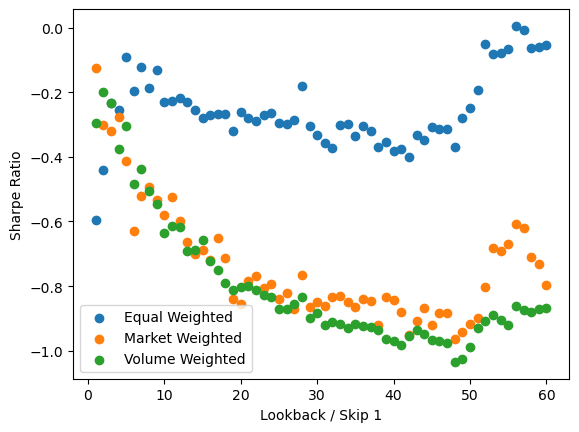

In [3]:
# your code below
SR = pd.DataFrame([], columns=["ew", "mw", "vw"], index=np.arange(1,61))

for j in SR.columns:
    for i in SR.index:
        avg = strategy(df,ngroups=10,lookback=i,skip=1,weight=j).mean()*12
        std = strategy(df,ngroups=10,lookback=i,skip=1,weight=j).std()*12**0.5
        SR.loc[i,j]=avg/std

plt.scatter(SR.index,SR["ew"], label="Equal Weighted")
plt.scatter(SR.index,SR["mw"], label="Market Weighted")
plt.scatter(SR.index,SR["vw"], label="Volume Weighted")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Lookback / Skip 1")
plt.legend()

    
    

In [4]:
# your discussion below


**Exercise 3**

Repeat what you did in 2.2, but now skipping 2 months

Discuss what you found.


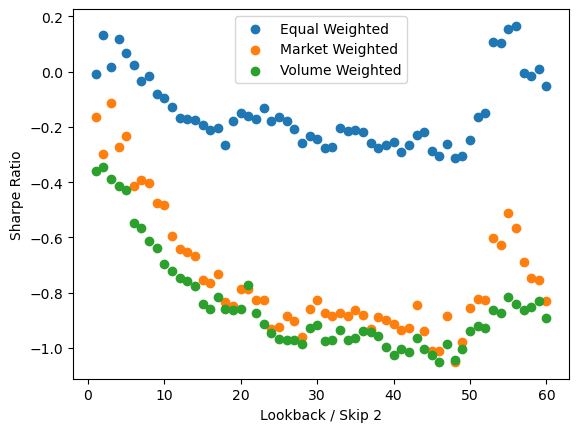

In [5]:
# your code below
SR_skip2 = pd.DataFrame([], columns=["ew", "mw", "vw"], index=np.arange(1,61))

for j in SR_skip2.columns:
    for i in SR_skip2.index:
        avg = strategy(df,ngroups=10,lookback=i,skip=2,weight=j).mean()*12
        std = strategy(df,ngroups=10,lookback=i,skip=2,weight=j).std()*12**0.5
        SR_skip2.loc[i,j]=avg/std

plt.scatter(SR_skip2.index,SR_skip2["ew"], label="Equal Weighted")
plt.scatter(SR_skip2.index,SR_skip2["mw"], label="Market Weighted")
plt.scatter(SR_skip2.index,SR_skip2["vw"], label="Volume Weighted")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Lookback / Skip 2")
plt.legend()

In [6]:
# your discussion below


**Exercise 4**

Do a for loop, where you do the standard momentum strategy (lookback 10, skip 2 months) using the following number of groups:  2,3,5,10,20, and 50 . Record the **Sharpe Ratio** for each of these. Plot the SR as a function of the number of groups. 

Discuss what you found.



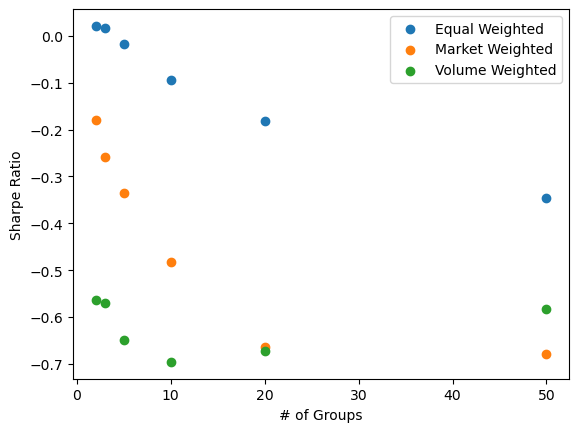

In [7]:
# your code below
SR_groups = pd.DataFrame([], columns=["ew", "mw", "vw"], index=[2,3,5,10,20,50])

for j in SR_groups.columns:
    for i in SR_groups.index:
        avg = strategy(df,ngroups=i,lookback=10,skip=2,weight=j).mean()*12
        std = strategy(df,ngroups=i,lookback=10,skip=2,weight=j).std()*12**0.5
        SR_groups.loc[i,j]=avg/std

plt.scatter(SR_groups.index,SR_groups["ew"], label="Equal Weighted")
plt.scatter(SR_groups.index,SR_groups["mw"], label="Market Weighted")
plt.scatter(SR_groups.index,SR_groups["vw"], label="Volume Weighted")
plt.ylabel("Sharpe Ratio")
plt.xlabel("# of Groups")
plt.legend()

In [8]:
# your discussion below


**Exercise 5**

Show that your code works, by doing a for loop, where you do the standard momentum strategy (lookback 10, skip 2, 10 groups) using all the **three weighting schemes** (Equal weighted, Value weighted and Volume weighted). Record and plot the Sharpe ratio

Discuss what you found.



**your code below**

Done above already for all strategies.

In [9]:
# your discussion below


**Exercise 6**

Does our strategy beat the CAPM?

**The goal here is to construct a function** that for a given time-series of a strategy excess returns it estimates the strategy alpha and beta with respect to the market excess return. It then reports the following objects


1. Annualized average excess returns
1. Annualized standard deviation
1. Annualize Sharpe Ratio
1. CAPM Beta
1. annualized CAPM alpha
1. Annualized Appraisal ratio
1. Maximum Sharpe Ratio obtained by investing optimally in the strategy and the market
1. Annualized standard deviation of strategy systematic risk
1. Annualized standard deviation of the strategy idiosyncratic risk




To do so you will need to  import also the market portfolio from this data set `url="https://raw.githubusercontent.com/amoreira2/Fin418/main/assets/data/MonthlyFactors.csv"` and merge with the time-series of your strategy.

TIPS:

 - To do that you will need to first construct your portfolios (so you have a time-series of returns for each), and then in the end, once you have the different portfolios in the columns and the dates in the rows, you will merge on date with the data frame that has the market returns.
 - It is very important that you import the monthly factors data set correctly for the merge to work
 - We have done that multiple times by now. 
 - also make sure that these returns are in the same units as your portfolio
 
 
 The function should look like that
 
 
 `output=perfeval(df,factor)`
 
 
where df is a dataframe containing your strategy excess returns or long-short returns, output is a Dataframe with 9 columns containing the desired outputs (name each column properly), and factor is the dataframe containing the market **excess** return. Please note that the data has **the market returns** and you need to compute the market excess return before merging.  


The function must merge df and factor, then run an OLS regression, and the output the desired quantities above.

Show that the function works by applying it to the standard Momentum strategy with value-weighted scheme (where you should simply use two functions, one built in question 2.1 to construct the strategy and the function that you just build to do performance evaluation).

In [10]:
# your code below
url="https://raw.githubusercontent.com/amoreira2/Fin418/main/assets/data/MonthlyFactors.csv"
factor = pd.read_csv(url)
factor["Date"] = pd.to_datetime(factor["Date"])

# Factors Excess Returns
factore = factor
factore.set_index("Date", inplace=True)
factore = factore.subtract(factore["RF"], axis=0)
factore.drop(columns=["RF"], axis=1, inplace=True)
factore = factore/100

# Strategy Returns
df2 = pd.DataFrame(strategy(df,ngroups=10,lookback=11,skip=2,weight="mw"), columns=["strategy"])


In [11]:
# Performance Evaluation Function

def perfval(df,factor):
    temp = pd.merge(factor, df, left_index=True, right_index=True)
    Results = pd.DataFrame([], index=["results"], columns=["mean", "std", "sr", "beta", "alpha", "appraisal", "max_sr", "syst_std", "idio_std"])
    Results["mean"] = temp["strategy"].mean()*12 # annualized average return of the strategy
    Results["std"] = temp["strategy"].std()*12**0.5 # annualized standard deviation of the strategy
    Results["sr"] = temp["strategy"].mean()*12/(temp["strategy"].std()*12**0.5) # annualized sharpe

    # CAPM 
    import statsmodels.api as sm
    x = temp[["MKT"]]
    x = sm.add_constant(x)
    y = temp[["strategy"]]
    model = sm.OLS(y, x).fit()

    Results["beta"] = model.params.iloc[1] # CAPM beta
    Results["alpha"] = model.params.iloc[0]*12 # annualized CAPM alpha
    Results["appraisal"] = model.params.iloc[0]*12/(model.resid.std()*12**0.5) # annualized appraisal ratio

    # Maximum Sharpe - MVE
    temp2 = temp[["MKT", "strategy"]]
    ERe = temp2.mean()
    Cove = temp2.cov()
    weights = ERe @ np.linalg.inv(Cove)
    Results["max_sr"] = (temp2 @ weights).mean()*12 / ((temp2 @ weights).std()*12**0.5)

    Results["syst_std"] = (((model.params.iloc[1]**2)*temp["MKT"].std()**2)**0.5)*12**0.5
    Results["idio_std"] = model.resid.std()*12**0.5

    return Results

perfval(df2, factore)



,mean,std,sr,beta,alpha,appraisal,max_sr,syst_std,idio_std
results,-0.243066,0.418867,-0.580293,-0.962522,-0.139749,-0.359541,0.753158,0.156115,0.388687


**Exercise 7** 
Searching for the best strategy

Now you have two functions. The first function construct a strategy, the second evaluates.

Propose  an algorithm that searches across the parameters of your strategy function for the best strategy across your dimension of choice. (No need to actually do it)


The `perfeval` function outputs several performance metrics. Choose one or combinations of the various metrics. Please explain your choice of metric. Explain briefly the idea behind your search algorithm.


**your answer below**

Open question.

**Exercise 8**

What is  the main pitfall/weakness of the approach taken in Exercise 7 to find the best strategy ?

Explain how you could modify this approach to improve the methodology with respect to this weakness (no need to do it!).

**your answer below**

Open question.


**Exercise 9**

Can you change the strategy function that you build in Exercise 1 to construct portfolios based on the last N months volatility?

Demonstrating that it works by applying the function to 10 groups using a rolling windown of 24 months to estimate the volatility signal.

In [12]:
# your code below
def strategy_volatility(df,ngroups=10,lookback=24,skip=2,weight="ew"):


    # This function takes a data frame with columns 'permno' = stock identifier, 'ret' = returns, 'date' = date,
    # 'shrout' = shares outstanding, 'prc' = price, 'vol' = volume traded;
    # It creates a volatility strategy with arguments lookback, for the lookback period, skip, for skipping a number of months
    # between the estimation and the portfolio formation period, and weight = {"ew", "mw", "vw"} which denotes
    # equal weighted, market weighted and volume weighted. The output is the return of a portfolio that goes 
    # long the group of assets with the highest volatility and shorts the group of assets with the lowest. 
    # ngroups is the number of groups we choose to partition the assets.
    
    df['mcap'] = df['prc'].abs()*df['shrout'] # creating the market cap column
    df['volatility'] = df['ret']
    df=df.set_index(['date'])
    temp=(df.groupby('permno')[['volatility']]).rolling(window=lookback,min_periods=int(np.ceil(lookback))).std()
    temp=temp.rename(columns={'volatility':'std'})
    temp=temp.reset_index()
    temp=pd.merge(df.reset_index(), temp[['permno','date','std']], how='left', on=['permno','date'])
    temp=temp.sort_values(['date','permno'])
    temp['volatility']=temp.groupby('permno')['std'].shift(skip)
    temp=temp.dropna(subset=['volatility'], how='any')
    temp['volatility_group']=temp.groupby(['date'], group_keys=False)['volatility'].apply(lambda x: pd.qcut(x, ngroups, \
                                                                           labels=False, duplicates='drop'))
    weight = weight
    if weight == "mw":
        volatility_w = temp.groupby(['date','volatility_group']).apply(lambda x:(x.ret*x.mcap).sum()/x.mcap.sum())
        volatility_w = volatility_w.unstack(level=-1)
    elif weight == "ew":
        volatility_w = temp.groupby(['date','volatility_group']).apply(lambda x: x.ret.mean())
        volatility_w = volatility_w.unstack(level=-1)
    else:
        volatility_w = temp.groupby(['date','volatility_group']).apply(lambda x:(x.ret*x.vol).sum()/x.vol.sum())
        volatility_w = volatility_w.unstack(level=-1)

    return volatility_w

strategy_volatility(df,ngroups=10,lookback=24,skip=2,weight="mw")

volatility_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2006-09-29,0.022223,0.126786,-0.042474,0.081775,0.027383,-0.009058,-0.063756,-0.003725,-0.005765,0.096934
2007-02-28,-0.016106,-0.023117,-0.014001,-0.014931,0.006244,-0.002879,-0.003287,0.015805,0.005216,0.011561
2007-03-30,0.010398,0.006673,0.021374,0.015154,0.006787,0.027851,0.033215,0.029549,0.012299,0.027917
2007-04-30,0.032058,0.049264,0.047798,0.046917,0.040715,0.046131,0.053184,0.070558,0.017216,0.069577
2007-05-31,0.025516,0.032097,0.051585,0.039436,0.039506,0.071600,0.058996,0.068664,0.053063,0.031408
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.062928,0.065230,0.107120,0.075833,0.054498,0.102004,0.088216,0.426654,0.221271,0.054760
2020-09-30,-0.023967,-0.022650,-0.067081,-0.028651,-0.037554,-0.017344,-0.020760,-0.062235,0.049970,0.100249
2020-10-30,-0.017459,-0.028329,-0.030038,0.008025,0.016313,0.006455,0.035930,0.104804,-0.045179,-0.052582


**Exercise 10**

Compute the expected returns, volatilities and Sharpe ratios of the 10 portfolios. Discuss your findings.

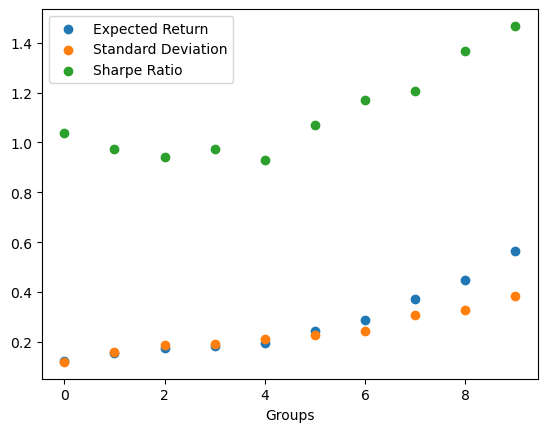

In [13]:
# your code below

# I ran the volatility strategy with market weighted portfolios.
volatility_strategy = strategy_volatility(df,ngroups=10,lookback=24,skip=2,weight="mw")
ER = volatility_strategy.mean()*12
Vol = volatility_strategy.std()*12**0.5
SR = ER/Vol

plt.scatter(ER.index, ER, label="Expected Return")
plt.scatter(ER.index, Vol, label="Standard Deviation")
plt.scatter(ER.index, SR, label="Sharpe Ratio")
plt.xlabel("Groups")
plt.legend()